This notebook examines the relationship between surges on the Pacific Coast. Timing and amplitude?

* Tofino
* Port Hardy
* Bamfield
* Toke Point
* Neah Bay
* Winter Harbour

Used to generate data for a table in the paper.

In [1]:
from salishsea_tools.nowcast import residuals
from salishsea_tools.nowcast import figures
from salishsea_tools import stormtools, tidetools

import pandas as pd

import matplotlib.pyplot as plt
import datetime
from dateutil import tz
import arrow
import requests
from cStringIO import StringIO
import numpy as np

%matplotlib inline

In [2]:
stns_NOAA ={'NeahBay': 9443090, 'TokePoint': 9440910}
stns_DFO = {'Tofino': 8615,'Bamfield': 8545, 'PortHardy': 8408, 'WinterHarbour': 8735}
MSLs={'Tofino': 2.103, 'Bamfield': 2.035, 'PortHardy': 2.896, 'NeahBay': 1.925, 'TokePoint': 2.836,
     'WinterHarbour': 2.205}
#lon/lat coords
coords = {'NeahBay': (-124.6,48.36), 'Tofino': (-125.91,49.15), 'Bamfield': (-125.14,48.84),
          'PortHardy': (-127.49,50.72),'TokePoint':(-123.97,46.71) ,'WinterHarbour': (-128.029 ,50.513)} 



In [3]:
def dateParserMeasured(s):

    PST=tz.tzoffset("PST",-28800)
    # Convert the string to a datetime object
    unaware = datetime.datetime.strptime(s, "%Y/%m/%d %H:%M")
    # Add in the local time zone (Canada/Pacific)
    aware = unaware.replace(tzinfo=PST)
    # Convert to UTC
    return aware.astimezone(tz.tzutc())

In [4]:
def dateparse_NOAA(s):
    """Parse the dates from the NOAA files."""

    PST=tz.tzoffset("PST",-28800)
    unaware = datetime.datetime.strptime(s, '%Y-%m-%d %H:%M')
    
    # Add in the local time zone (Canada/Pacific)
    aware = unaware.replace(tzinfo=PST)
    # Convert to UTC
    return aware.astimezone(tz.tzutc())

In [5]:
def get_NOAA(station_no, start_date, end_date, product):
    """Retrieves recent NOAA water levels from a station in a given date range.

    NOAA water levels are at 6 minute intervals and are relative to
    mean sea level.
    See: http://tidesandcurrents.noaa.gov/stations.html?type=Water+Levels.

    :arg station_no: NOAA station number.
    :type station_no: int

    :arg start_date: The start of the date range; e.g. 01-Jan-2014.
    :type start_date: str

    :arg end_date: The end of the date range; e.g. 02-Jan-2014.
    :type end_date: str

    :returns: DataFrame object (obs) with time and wlev columns,
              among others that are irrelevant.
    """

    # Time range
    st_ar = arrow.Arrow.strptime(start_date, '%d-%b-%Y')
    end_ar = arrow.Arrow.strptime(end_date, '%d-%b-%Y')

    base_url = (
        'http://tidesandcurrents.noaa.gov/api/datagetter?')
    params = {
        'product': product,
        'application': 'NOS.COOPS.TAC.WL',
        'begin_date': st_ar.format('YYYYMMDD'),
        'end_date': end_ar.format('YYYYMMDD'),
        'datum': 'STND',
        'station': str(station_no),
        'time_zone': 'GMT',
        'units': 'metric',
        'format': 'csv',
    }
    response = requests.get(base_url, params=params)

    fakefile = StringIO(response.content)
    try:
        obs = pd.read_csv(
            fakefile, parse_dates=[0], date_parser=figures.dateparse_NOAA)
    except ValueError:
        data = {'Date Time': st_ar.datetime, ' Water Level': float('NaN')}
        obs = pd.DataFrame(data=data, index=[0])
    if product == 'hourly_height':
        obs = obs.rename(columns={'Date Time': 'time', ' Water Level': 'wlev'})
    elif product == 'predictions':
        obs = obs.rename(columns={'Date Time': 'time', ' Prediction': 'pred'})
    return obs

In [6]:
def compare_residuals(year):
    fig,ax = plt.subplots(1,1,figsize=(15,5))
    tides = {}; obs={}; res={}; time={}
    
    #DFO
    for key,num in stns_DFO.iteritems():
        #tides
        fname =('../Revisions/tides/'
        'forcing/{}_t_tide_compare8_31-Dec-{}_02-Jan-{}_snr2_filter.csv'.format(key,year-1,year+1))
        tides, msl = stormtools.load_tidal_predictions(fname)
        msl=MSLs[key]
        
        #observations
        filename ='../Revisions/tides/wlev_{}_31-Dec-{}_02-Jan-{}.csv'.format(num,year-1,year+1)
        obs = pd.read_csv(filename,skiprows=7,parse_dates=[0],date_parser=dateParserMeasured)
        obs = obs.rename(columns={'Obs_date': 'time', 'SLEV(metres)': 'slev'})
        
        res[key] = residuals.calculate_residual(obs.slev, obs.time, tides.pred_all+msl,tides.time)
        time[key]=obs.time
        ax.plot(time[key],res[key],label=key,lw=1.5)
        
    #NOAA
    for key in ('NeahBay', 'TokePoint'):
        #tides
        fname = ('../Revisions/tides/'
        '{}_t_tide_compare8_31-Dec-{}_02-Jan-{}_snr2_filter.csv'.format(key,year-1,year+1))
        tides, msl = stormtools.load_tidal_predictions(fname)
        msl=MSLs[key]
        print msl
        #observations
        filename = '../Revisions/tides/{}_31-Dec-{}_02-Jan-{}.csv'.format(key,year-1,year+1)
        obs = pd.read_csv(filename, skiprows=2, parse_dates=[0], date_parser=dateparse_NOAA)
        obs = obs.rename(columns={'Date Time': 'time', ' Water Level': 'wlev'})
        #residuals
        res[key]=residuals.calculate_residual(obs.wlev, obs.time, tides.pred_all,tides.time)
        time[key]=obs.time
        ax.plot(time[key],res[key],label=key,lw=1.5)
    
    ax.legend()
    ax.grid()
    
    return fig,ax,res,time

In [7]:
def compare_peaks(t1,t2,residuals,time,yr):
    epoch = datetime.datetime(yr,1,1)
    epoch=epoch.replace(tzinfo=tz.tzutc())
    
    res_max={}
    time_max={}
    
    for key, res in residuals.iteritems():
        
        time_array = np.array(time[key])
        res_array = np.array(res)
        #truncate data
        inds = np.where(np.logical_and(time_array <= t2, time_array >= t1))
        
        res_trun = res_array[inds]
        time_trun = time_array[inds]
        
        ind_max = np.argmax(res_trun)
        res_max[key] = np.array([res_trun[ind_max]])
        date_max  = time_trun[ind_max]
        time_max[key] = np.array([(date_max-epoch).total_seconds()/3600])
    
        print '{}: Max residual: {}, Time max: {}'.format(key, res_max[key][0], date_max.strftime('%d-%b-%Y %H:%M') )
        
    res_d = pd.DataFrame(res_max)
    time_d = pd.DataFrame(time_max)
        
    return res_d, time_d

# 2006

Here, grab observations if needed, and run the tidal predictions.

In [8]:
yr=2006
start= '31-Dec-{}'.format(yr-1)
end = '02-Jan-{}'.format(yr+1)




1.925
2.836


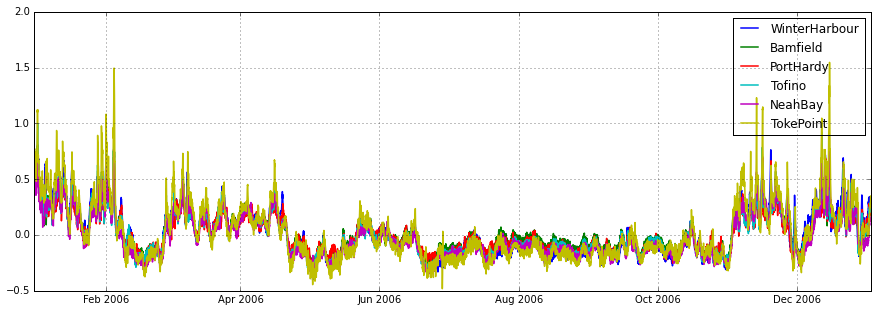

In [9]:
fig,ax,res,time = compare_residuals(yr)


## Isolating several surge events

WinterHarbour: Max residual: 0.789631, Time max: 04-Feb-2006 13:00
NeahBay: Max residual: 0.763856, Time max: 04-Feb-2006 16:00
TokePoint: Max residual: 1.495532, Time max: 04-Feb-2006 15:00
Bamfield: Max residual: 0.795915, Time max: 04-Feb-2006 12:00
PortHardy: Max residual: 0.615325, Time max: 04-Feb-2006 14:00
Tofino: Max residual: 0.902445, Time max: 04-Feb-2006 14:00


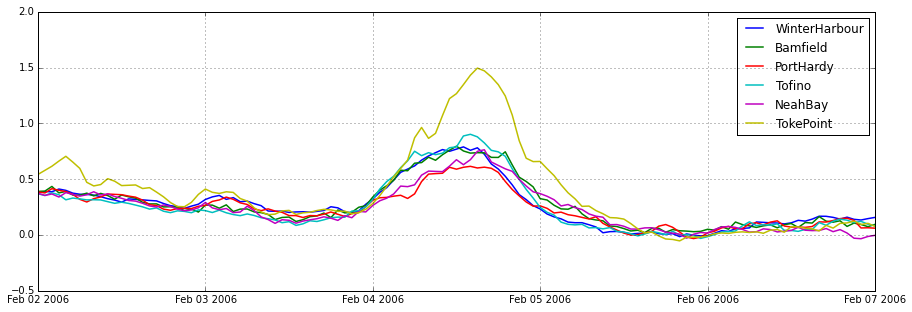

In [10]:
t1=datetime.datetime(2006,2,2)
t1=t1.replace(tzinfo=tz.tzutc())
t2=datetime.datetime(2006,2,7)
t2=t2.replace(tzinfo=tz.tzutc())

ax.set_xlim(t1,t2)

res_data, time_data =compare_peaks(t1,t2,res,time,yr)

fig

In [11]:
print time_data

   Bamfield  NeahBay  PortHardy  Tofino  TokePoint  WinterHarbour
0       828      832        830     830        831            829


WinterHarbour: Max residual: 0.518616, Time max: 15-Dec-2006 02:00
NeahBay: Max residual: 0.75266, Time max: 15-Dec-2006 06:00
TokePoint: Max residual: 1.547046, Time max: 15-Dec-2006 08:00
Bamfield: Max residual: 0.726103, Time max: 15-Dec-2006 06:00
PortHardy: Max residual: 0.536348, Time max: 15-Dec-2006 04:00
Tofino: Max residual: 0.699467, Time max: 15-Dec-2006 06:00


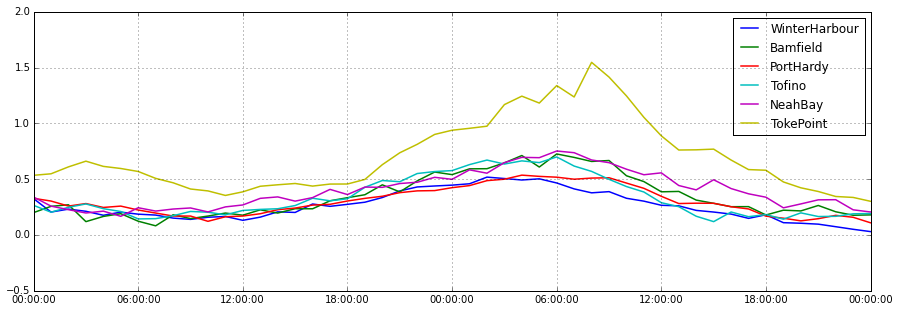

In [12]:
t1=datetime.datetime(2006,12,14)
t1=t1.replace(tzinfo=tz.tzutc())
t2=datetime.datetime(2006,12,16)
t2=t2.replace(tzinfo=tz.tzutc())

ax.set_xlim(t1,t2)

res_d,time_d=compare_peaks(t1,t2,res,time,yr)

res_data = res_data.append(res_d)
time_data =time_data.append(time_d)
fig

WinterHarbour: Max residual: 0.536515, Time max: 15-Nov-2006 15:00
NeahBay: Max residual: 0.694008, Time max: 16-Nov-2006 01:00
TokePoint: Max residual: 1.147581, Time max: 16-Nov-2006 01:00
Bamfield: Max residual: 0.707483, Time max: 15-Nov-2006 21:00
PortHardy: Max residual: 0.44256, Time max: 15-Nov-2006 22:00
Tofino: Max residual: 0.784133, Time max: 15-Nov-2006 19:00


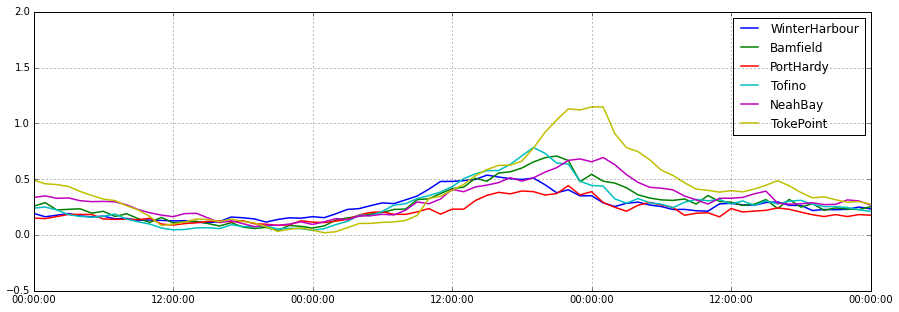

In [13]:
t1=datetime.datetime(2006,11,14)
t1=t1.replace(tzinfo=tz.tzutc())
t2=datetime.datetime(2006,11,17)
t2=t2.replace(tzinfo=tz.tzutc())

ax.set_xlim(t1,t2)

res_d,time_d=compare_peaks(t1,t2,res,time,yr)

res_data = res_data.append(res_d)
time_data =time_data.append(time_d)
fig

# 2009

In [14]:
yr=2009
start= '31-Dec-{}'.format(yr-1)
end = '02-Jan-{}'.format(yr+1)


1.925
2.836


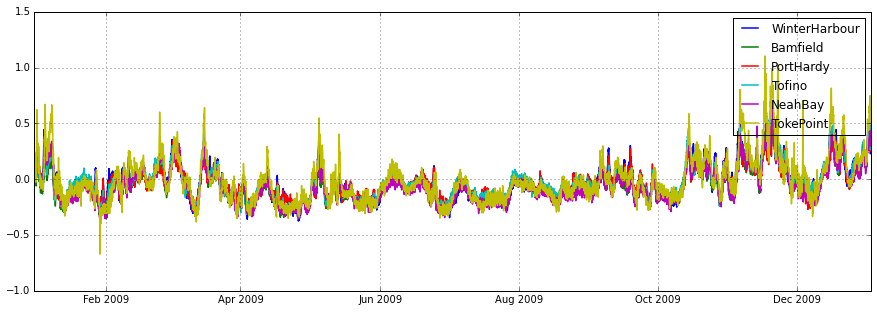

In [15]:
fig,ax,res,time = compare_residuals(yr)

WinterHarbour: Max residual: 0.543902, Time max: 19-Nov-2009 01:00
NeahBay: Max residual: 0.472957, Time max: 19-Nov-2009 02:00
TokePoint: Max residual: 0.833552, Time max: 19-Nov-2009 08:00
Bamfield: Max residual: 0.502639, Time max: 19-Nov-2009 02:00
PortHardy: Max residual: 0.435186, Time max: 19-Nov-2009 08:00
Tofino: Max residual: 0.608416, Time max: 19-Nov-2009 01:00


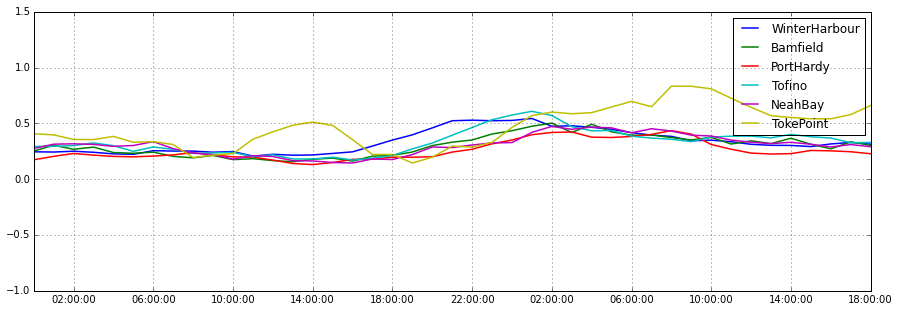

In [16]:
t1=datetime.datetime(2009,11,18)
t1=t1.replace(tzinfo=tz.tzutc())
t2=datetime.datetime(2009,11,19,18)
t2=t2.replace(tzinfo=tz.tzutc())

ax.set_xlim(t1,t2)

res_d,time_d=compare_peaks(t1,t2,res,time,yr)

res_data = res_data.append(res_d)
time_data =time_data.append(time_d)
fig

WinterHarbour: Max residual: 0.557416, Time max: 20-Nov-2009 10:00
NeahBay: Max residual: 0.654483, Time max: 20-Nov-2009 04:00
TokePoint: Max residual: 0.984884, Time max: 20-Nov-2009 03:00
Bamfield: Max residual: 0.59014, Time max: 20-Nov-2009 04:00
PortHardy: Max residual: 0.492591, Time max: 20-Nov-2009 10:00
Tofino: Max residual: 0.650482, Time max: 20-Nov-2009 02:00


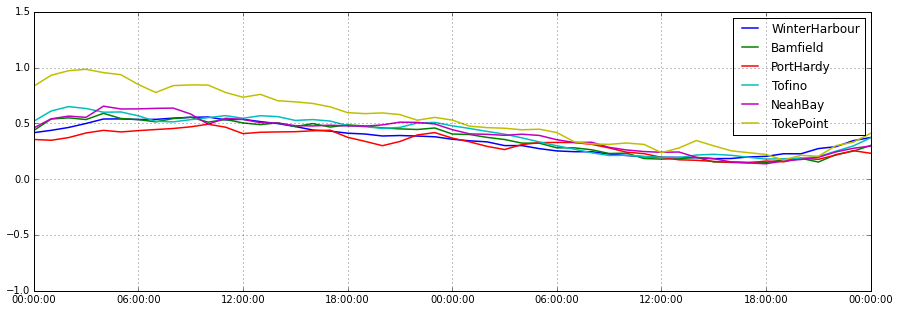

In [17]:
t1=datetime.datetime(2009,11,20)
t1=t1.replace(tzinfo=tz.tzutc())
t2=datetime.datetime(2009,11,22)
t2=t2.replace(tzinfo=tz.tzutc())

ax.set_xlim(t1,t2)

res_d,time_d=compare_peaks(t1,t2,res,time,yr)

res_data = res_data.append(res_d)
time_data =time_data.append(time_d)
fig

# 2012

In [18]:
yr=2012
start= '31-Dec-{}'.format(yr-1)
end = '02-Jan-{}'.format(yr+1)


1.925
2.836


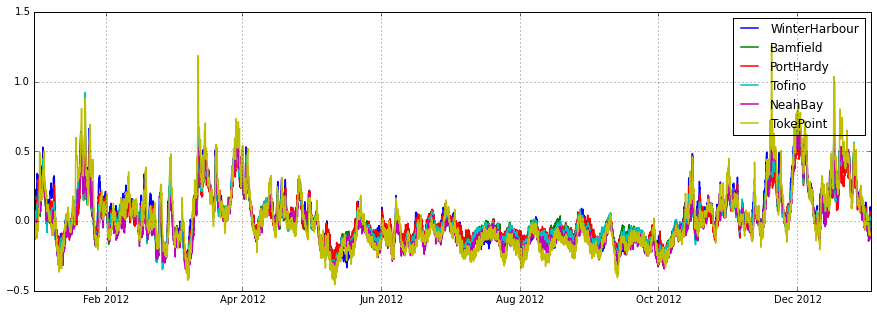

In [19]:
fig,ax,res,time = compare_residuals(yr)

WinterHarbour: Max residual: 0.487716, Time max: 17-Dec-2012 04:00
NeahBay: Max residual: 0.607183, Time max: 17-Dec-2012 05:00
TokePoint: Max residual: 1.035296, Time max: 17-Dec-2012 05:00
Bamfield: Max residual: 0.628586, Time max: 17-Dec-2012 05:00
PortHardy: Max residual: 0.422664, Time max: 17-Dec-2012 05:00
Tofino: Max residual: 0.595176, Time max: 17-Dec-2012 05:00


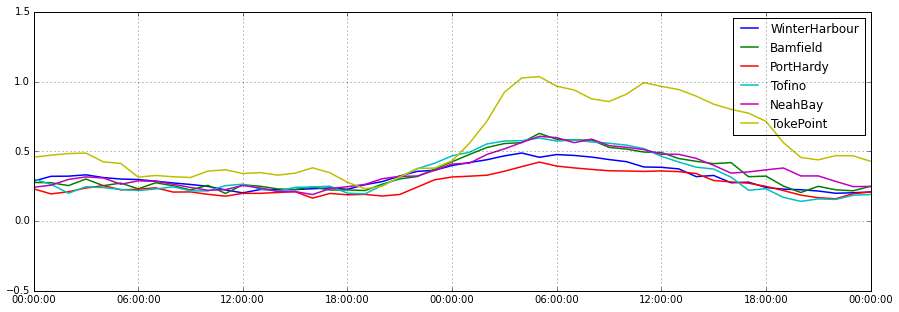

In [20]:
t1=datetime.datetime(2012,12,16)
t1=t1.replace(tzinfo=tz.tzutc())
t2=datetime.datetime(2012,12,18)
t2=t2.replace(tzinfo=tz.tzutc())

ax.set_xlim(t1,t2)

res_d,time_d=compare_peaks(t1,t2,res,time,yr)

res_data = res_data.append(res_d)
time_data =time_data.append(time_d)
fig

# Summary

Bamfield         0.658478
NeahBay          0.657524
PortHardy        0.490779
Tofino           0.706686
TokePoint        1.173982
WinterHarbour    0.572299
dtype: float64


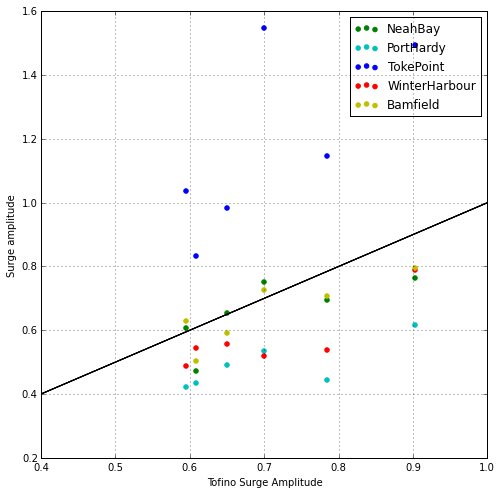

In [21]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
lists=['NeahBay','PortHardy','TokePoint','WinterHarbour','Bamfield']
colors=['g','c','b','r','y','k', 'm']
for key , c in zip(lists,colors):
    res_data.plot(x='Tofino',y=key,kind='scatter',ax=ax,color=c,label=key)

    ax.plot([0.2,1.6],[0.2,1.6],'-k')
ax.set_ylabel('Surge amplitude')
ax.set_xlabel('Tofino Surge Amplitude')
ax.set_xlim([0.4,1.0])
ax.set_ylim([0.2,1.6])

print res_data.mean()

* Neah Bay surge is often smaller in amplitude. 
* Bamfield and Tofino are very similar. 
* Toke Point is often larger in amplitude
* Port Hardy often smaller
* Black line is the one-to-one line

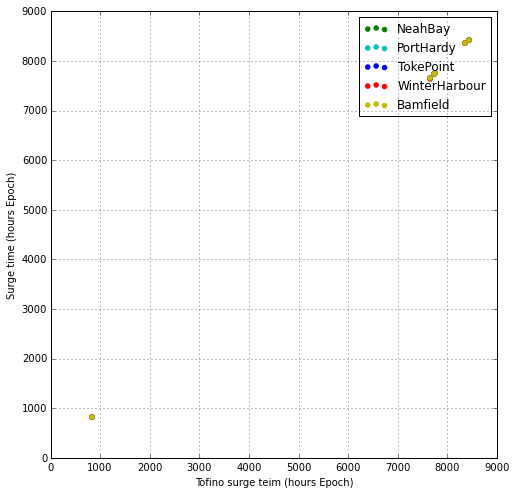

In [22]:
fig,ax=plt.subplots(1,1,figsize=(8,8))

for key , c in zip(lists,colors):
    time_data.plot(x='Tofino',y=key,kind='scatter',ax=ax,color=c,label=key)

ax.set_ylabel('Surge time (hours Epoch)')
ax.set_xlabel('Tofino surge teim (hours Epoch)')

Really not very helpful

NeahBay Mean offset (hours): -1.83333333333
PortHardy Mean offset (hours): -2.66666666667
TokePoint Mean offset (hours): -2.83333333333
WinterHarbour Mean offset (hours): 0.333333333333
Bamfield Mean offset (hours): -0.5


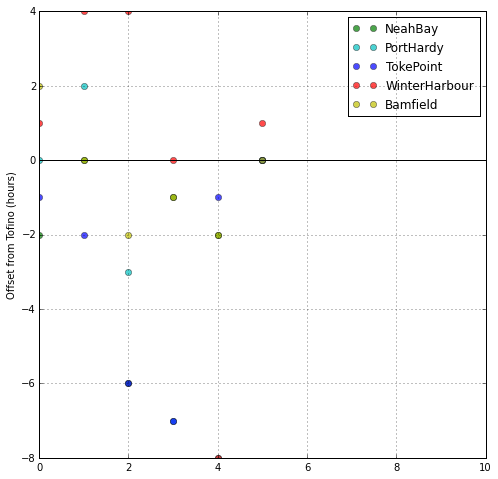

In [23]:
fig,ax=plt.subplots(1,1, figsize=(8,8))

for key , c in zip(lists,colors):
    ax.plot(time_data['Tofino'] -time_data[key],'o',color=c,label=key,alpha=0.7)
    print key, 'Mean offset (hours):', (time_data['Tofino'] -time_data[key]).mean()
ax.plot([0, 10], [0,0],'-k')
ax.legend()
ax.grid()
#ax.set_ylim([-10,10])
ax.set_ylabel('Offset from Tofino (hours)')

* Toke Point timing is variable. Two significantly earlier surges skew the mean.
* Bamfield surge super close to Tofino surge in timing
* Only looking at 11 surge events so is this statistically significant?
* NB and Port Hardy are usually later than Tofino.
* There may be a better criterion for selecting the surge max and timing. How would I define something like surge duration? Time span of +- 50% of max? Search for an inflection point?

In [24]:
from mpl_toolkits.basemap import Basemap

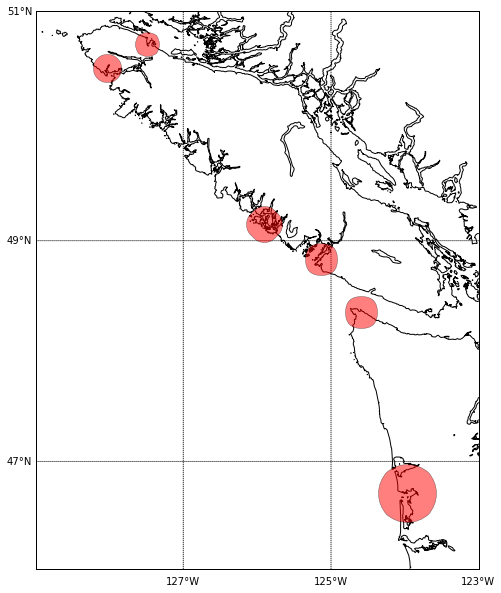

In [25]:
fig = plt.figure(figsize=(10,10))
map = Basemap(projection='merc', lat_0=49, lon_0=-123,
              resolution = 'h', area_thresh = 0.1,
              llcrnrlon=-129, llcrnrlat=46,
              urcrnrlon=-123, urcrnrlat=51)

map.drawcoastlines()
#map.fillcontinents(color='burlywood')


map.drawmeridians([-127, -125, -123], labels=[1,0,0,1])
map.drawparallels([47, 49, 51],labels=[1,0,0,1])

for key, c in coords.iteritems():
    x,y = map(c[0],c[1])
    map.plot(x, y,'ro', markersize=res_data[key].mean()*50,alpha=0.5)

#reference 
#map.plot(x, y,'ro', markersize=res_data['Tofino'].mean()*50,
#         label = ' {} m'.format(res_data['Tofino'].mean()),alpha =0.5)
#plt.legend(loc=3)


plt.show()

I don't think this will be useful...